<a target="_blank" href="https://colab.research.google.com/github/cyneuro/ML_camp/blob/main/camp_logreg_microbit.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Logistic regression with micro:bit
## Team MNP

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 1. Read and preprocess the data

- Read the recorded dataset.
- Compute velocity and position from acceleration.

In [3]:
# Convert milligravities to m/s2
MG_TO_MS2 = 0.00980665

def process_data(data):
    # Clean the columns
    orig_columns = ["time (seconds)", "x", "y", "z"]
    new_columns = ["t", "ax", "ay", "az"]
    data = data[orig_columns]
    data.columns = new_columns

    # Clean NaNs
    data = data.dropna()

    # Convert to m/s2
    for acc in ['ax', 'ay', 'az']:
        data[acc] = data[acc] * MG_TO_MS2

    # Replace outliers with the median
    for acc in ['ax', 'ay', 'az']:
        acc_raw = data[acc].copy()
        acc_raw[np.abs(acc_raw / np.median(acc_raw)) > 1.5] = np.median(acc_raw)
        data[acc] = acc_raw

    # Compute velocity
    data['vx'] = cumulative_trapezoid(data['ax'], data['t'], initial = 0)
    data['vy'] = cumulative_trapezoid(data['ay'], data['t'], initial = 0)
    data['vz'] = cumulative_trapezoid(data['az'], data['t'], initial = 0)

    # Compute position
    data['x'] = cumulative_trapezoid(data['vx'], data['t'], initial = 0)
    data['y'] = cumulative_trapezoid(data['vy'], data['t'], initial = 0)
    data['z'] = cumulative_trapezoid(data['vz'], data['t'], initial = 0)

    return data

In [4]:
data = pd.read_csv("shake_data.csv")
data = process_data(data)
data.head()

,t,ax,ay,az,vx,vy,vz,x,y,z
0,0.000,4.118793,0.666852,-9.649744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.052,3.765754,0.549172,-9.335931,0.204998,0.031617,-0.493628,0.005330,0.000822,-0.012834
2,0.104,4.471832,0.000000,-9.257478,0.419175,0.045895,-0.977056,0.021558,0.002837,-0.051072
3,0.157,5.021005,0.353039,-8.355266,0.670736,0.055251,-1.443794,0.050441,0.005518,-0.115225
4,0.209,4.393379,0.196133,-9.257478,0.915510,0.069529,-1.901725,0.091683,0.008762,-0.202208


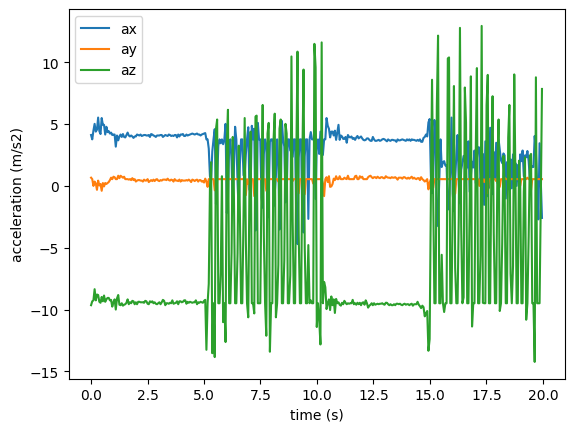

In [5]:
for acc in ['ax', 'ay', 'az']:
    plt.plot(data['t'], data[acc], label = acc)
plt.xlabel("time (s)")
plt.ylabel("acceleration (m/s2)")
plt.legend()

## 2. Split into train and test samples.
- Train: the first shake.
- Test: the second shake.

In [17]:
#TODO: adjust to your values

train_rest = (0.1, 5.0) # (seconds)
train_shake = (5.1, 10.0) # (seconds)

test_rest = (10.1, 15.0) # (seconds)
test_shake = (15.1, 20.0) # (seconds)

In [18]:
def construct_Xy(data, window_rest, window_shake):
    X = pd.concat((
        data.loc[(data['t'] >= window_rest[0]) & (data['t'] <= window_rest[1]), ['t', 'ax', 'ay', 'az']],
        data.loc[(data['t'] >= window_shake[0]) & (data['t'] <= window_shake[1]), ['t', 'ax', 'ay', 'az']],
    ))
    y = np.ones(len(X))
    y[(X['t'] >= window_rest[0]) & (X['t'] <= window_rest[1])] = 0

    return X, y

In [19]:
X_train, y_train = construct_Xy(data, train_rest, train_shake)
X_test, y_test = construct_Xy(data, test_rest, test_shake)

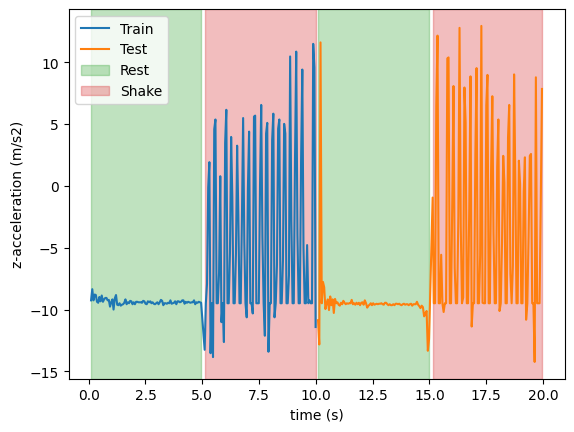

In [20]:
plt.plot(X_train['t'], X_train["az"], label = "Train")
plt.plot(X_test['t'], X_test["az"], label = "Test")

label_set = False
for X, y in [(X_train, y_train), (X_test, y_test)]:
    for y_value, y_label in enumerate(["Rest", "Shake"]):
        plt.axvspan(
            X['t'].to_numpy()[np.where(y == y_value)[0][0]],
            X['t'].to_numpy()[np.where(y == y_value)[0][-1]],
            alpha = 0.3,
            color = "tab:green" if y_value == 0 else "tab:red",
            label = y_label if not label_set else None
            )
    label_set = True

plt.xlabel("time (s)")
plt.ylabel("z-acceleration (m/s2)")
plt.legend()

## 3. Train a logistic regression model

Compare 2 models.

**Model 1.**

$$
\hat{p} = \sigma(b_0 + b_t \times t + b_x \times a_x + b_y \times a_y + b_z \times a_z)
$$

**Model 2.**

$$
\hat{p} = \sigma(b_0 + b_x \times a_x + b_y \times a_y + b_z \times a_z)
$$

In [21]:
model1 = LogisticRegression()
model1.fit(X_train[["t", "ax", "ay", "az"]], y_train)

model2 = LogisticRegression()
model2.fit(X_train[["ax", "ay", "az"]], y_train)

LogisticRegression()

In [22]:
print("ACCURACY")
print("--------")
print("Model\tTrain\tTest")
for model_id, (model, features) in enumerate((
    (model1, ["t", "ax", "ay", "az"]),
    (model2, ["ax", "ay", "az"])
    )):
    train_acc = round(accuracy_score(y_train, model.predict(X_train[features])), 2)
    test_acc = round(accuracy_score(y_test, model.predict(X_test[features])), 2)
    print(f"M{model_id}\t{train_acc}\t{test_acc}")

ACCURACY
--------
Model	Train	Test
M0	1.0	0.49
M1	0.8	0.86


In [23]:
model1.predict(X_test[["t", "ax", "ay", "az"]])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [24]:
model2.predict(X_test[["ax", "ay", "az"]])

array([1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

### Question

Explain the observed difference between predictions of the two models.

**Hint: compare the decision lines.**

## Answer:

There is a difference because Model 1 includes time as a feature and learns to classify based on when the motion occurred rather than how the device moved. Since rest and shake happen in seperate time intervals in the training data, Model 1 learns a time-based decision boundary and overfits to the recording schedule. This lets model 1 achieve perfect training accuracy but at a cost of poor generalization.

Model 2 does not use time and instead relies solely on acceleration values. Therefore, it learns a physically meaningful boundary by using the pure motion behavior. This results in a more realistic prediction and a little better generalization when it comes to the second shake interval.

In [25]:
print(f"Model1: intercept = {model1.intercept_}, coef = {model1.coef_}")
print(f"Model2: intercept = {model2.intercept_}, coef = {model2.coef_}")

Model1: intercept = [-10.42574755], coef = [[ 2.81013801 -1.17086127 -0.26064589 -0.08259565]]
Model2: intercept = [8.79869243], coef = [[-2.12662407 -0.60198071  0.06413404]]


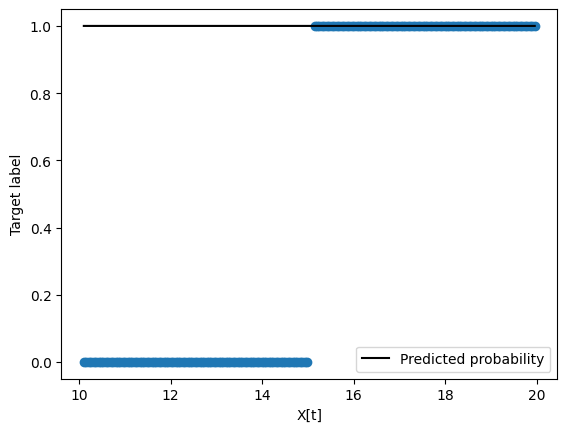

In [26]:
plt.scatter(X_test["t"], y_test)
plt.xlabel("X[t]")
plt.ylabel("Target label")

plt.plot(X_test["t"], model1.predict_proba(X_test[["t", "ax", "ay", "az"]])[:, 1], label = "Predicted probability", c = "black")
plt.legend()

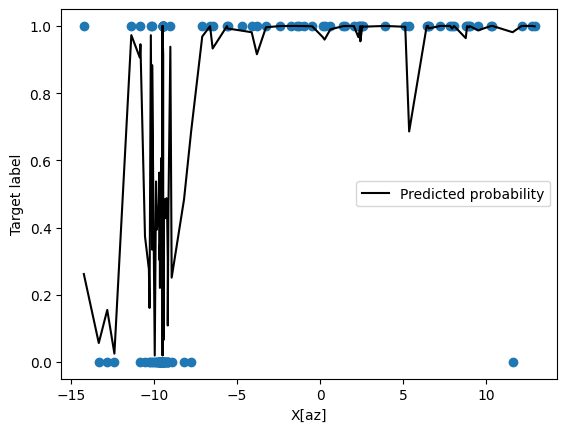

In [27]:
plt.scatter(X_test["az"], y_test)
plt.xlabel("X[az]")
plt.ylabel("Target label")

plt.plot(X_test.sort_values("az")["az"], model2.predict_proba(X_test.sort_values("az")[["ax", "ay", "az"]])[:, 1], label = "Predicted probability", c = "black")
plt.legend()